In [1]:
!pip install chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.7 MB/s eta 0:00:00


In [2]:
#Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import chess
from chess import Board
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
#Loading in the data, which is a CSV file containing chess positions in FEN format
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Chess Evaluator/chess_data.csv'
df = pd.read_csv(DATA_PATH)

In [4]:
#Removing all NaN values
df = df.dropna()

In [6]:
#Index of the layer dedicated to each piece.
piece_layer = {'p': 0, 'k': 1, 'n': 2, 'b': 3, 'r': 4, 'q': 5, 'P': 6, 'K': 7, 'N': 8, 'B': 9, 'R': 10, 'Q': 11}

#Function to convert Chess FEN format into 14 x 8 x 8 matrix for the neural netowrk
def fen_to_matrix(fen):

  #initializing matrix
  matrix = np.zeros((14, 8, 8))

  #Get only the peice placement from the FEN
  positional_fen = fen.split(' ')[0]
  positional_fen = positional_fen.split('/')

  #Populating the matrix
  for row in range(8):
    fen_col, matrix_col = 0, 0
    while fen_col < len(positional_fen[row]):

      piece = positional_fen[row][fen_col]

      #If character is a peice
      if piece in piece_layer:

        matrix[piece_layer[piece]][row][matrix_col] = 1
        matrix_col += 1

      #If character is a number
      else:

        matrix_col += int(piece)

      fen_col += 1

    #from the FEN, generate a board
    position = Board(fen)

    #Populate the 13th layer of the matrix with the sqaures the white 'sees'
    position.turn = chess.WHITE
    for move in position.legal_moves:

      square = move.to_square
      matrix[12][7 - (square >> 3)][square & 7] = 1

    #Populate the 14th layer of the matrix with the sqaures the black 'sees'
    position.turn = chess.BLACK
    for move in position.legal_moves:

      square = move.to_square
      matrix[13][7 - (square >> 3)][square & 7] = 1

  return matrix

In [7]:
def build_model(conv_size, conv_depth):
  board3d = Input(shape=(14, 8, 8))
  x = board3d
  for _ in range(conv_depth):
    x = Conv2D(filters=conv_size, kernel_size=3,
    padding='same', activation='relu')(x)
  x = Flatten()(x)
  x = Dense(64, 'relu')(x)
  x = Dense(1, 'sigmoid')(x)

  return Model(inputs=board3d, outputs=x)

model = build_model(64, 4)

In [8]:
df['Position_Matrix'] = df['Position'].apply(fen_to_matrix)

KeyboardInterrupt: 

In [ ]:
#Normalize the evaluations to be between 0 and 1
evaluations = df[' Centipawn Evaluation'].values
evaluations = (evaluations / abs(evaluations).max() / 2) + 0.5

#placing positional matrices into an array
positional_matrices = df['Position_Matrix'].values
positional_matrices = [tf.convert_to_tensor(matrix) for matrix in positional_matrices]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((positional_matrices, evaluations))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(positional_matrices))

# Split the dataset into train and test
train_size = int(0.8 * len(positional_matrices))
test_size = len(positional_matrices) - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Optionally, batch and prefetch the datasets
batch_size = 1000
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Chess Evaluator/'
model_checkpointing_callback = ModelCheckpoint(filepath = checkpoint_filepath, save_best_only= True)
early_stopping_callback = EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)

model.fit(train_dataset,
          batch_size=1000,
          epochs=500,
          verbose=1,
          validation_data=test_dataset,
          callbacks=[early_stopping_callback , model_checkpointing_callback])

model.save('/content/drive/MyDrive/Colab Notebooks/Chess Evaluator/model.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 8, 64)         4672      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 7168)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                4588

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(test_dataset)

8/8 [==============================] - 0s 21ms/step - loss: 2.1780e-04


0.00021780410315841436

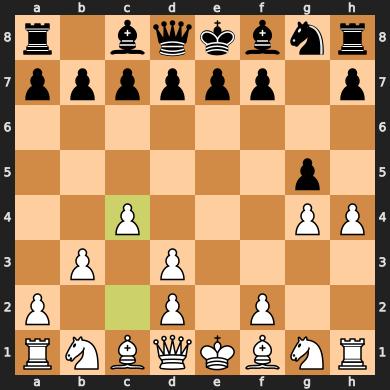

In [ ]:
import random

board = Board()

for _ in range(random.randint(1, 35)):

  move = random.choice(list(board.legal_moves))
  board.push(move)

  if board.is_checkmate():
    break

board

In [5]:
matrix = fen_to_matrix(board.fen())
model.predict(matrix.reshape(1, 14, 8, 8))

NameError: name 'fen_to_matrix' is not defined